In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from torchsummary import summary
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,TensorDataset
import torch.nn as nn
import torch
import torch.nn.functional as F
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

data_dir = "/content/drive/MyDrive/xrays"




dataset = ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((224,224)),transforms.ToTensor()
]))

In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 1664
    Root location: /content/drive/MyDrive/xrays
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [ ]:

img, label = dataset[0]
print(img.shape,label)

torch.Size([3, 224, 224]) 0


Label : Fractured


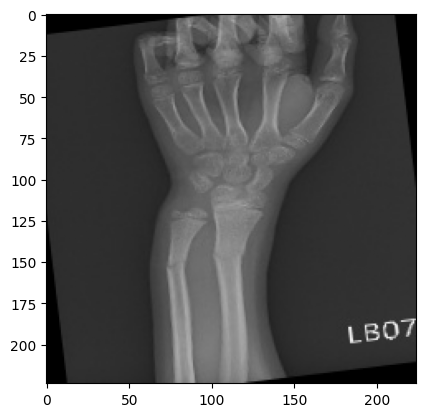

In [ ]:

def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")

    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*dataset[7])

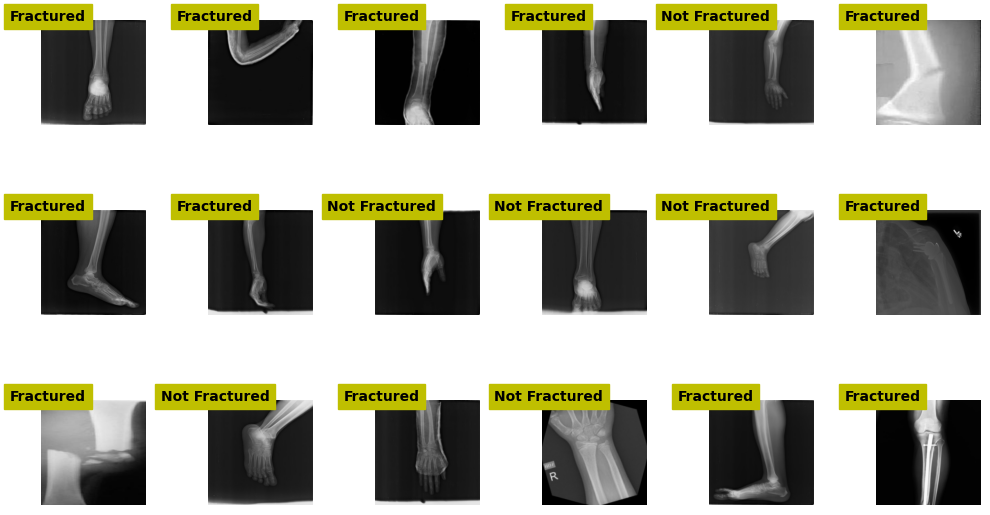

In [ ]:
# inspect a few random images

fig,axs = plt.subplots(3,6,figsize=(10,6))

for (i,ax) in enumerate(axs.flatten()):
   img, label = dataset[random.randint(0,1664)]
   ax.imshow(img.permute(1,2,0))
   ax.text(14,0,dataset.classes[label],ha='center',fontweight='bold',color='k',backgroundcolor='y')
   ax.axis('off')


plt.tight_layout()
plt.show()

In [ ]:
len(dataset)

1664

In [ ]:
labels=torch.zeros(1664)

In [ ]:
j=0
for i in dataset:
    labels[j]=i[1]
    j=j+1

In [ ]:
labels=labels.long()
len(labels)

1664

In [ ]:
data=[]

In [ ]:
j=0
for i in dataset:

    data.append(i[0].tolist())
    j=j+1

In [ ]:
len(data[0])

3

In [ ]:
data=torch.tensor(data)

In [ ]:
len(data)

1664

In [ ]:
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=0.3,random_state=42)



train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


# batchsize    = 16
train_loader = DataLoader(train_data,batch_size=16,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
def createThexray(printtoggle=False):

  class xrayNet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      ### convolution layers
      self.conv1 = nn.Conv2d( 3,10,kernel_size=5,stride=1,padding=1)


      self.conv2 = nn.Conv2d(10,20,kernel_size=5,stride=1,padding=1)
      # size: 54

      # compute the number of units in FClayer (number of outputs of conv2)
      expectSize = np.floor( (54+2*0-1)/1 ) + 1 # fc1 layer has no padding or kernel, so set to 0/1
      expectSize = 20*int(expectSize**2)

      ### fully-connected layer
      self.fc1 = nn.Linear(expectSize,50)

      ### output layer
      self.out = nn.Linear(50,2)


      self.print = printtoggle

    # forward pass
    def forward(self,x):

      print(f'Input: {x.shape}') if self.print else None

      # convolution -> maxpool -> relu
      x = F.relu(F.max_pool2d(self.conv1(x),2))
      print(f'Layer conv1/pool1: {x.shape}') if self.print else None


      x = F.relu(F.max_pool2d(self.conv2(x),2))
      print(f'Layer conv2/pool2: {x.shape}') if self.print else None

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorize: {x.shape}')


      x = F.relu(self.fc1(x))
      if self.print: print(f'Layer fc1: {x.shape}')
      x = self.out(x)
      if self.print: print(f'Layer out: {x.shape}')

      return x

  # model
  net = xrayNet(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [ ]:
net,lossfun,optimizer = createThexray(True)

X,y = next(iter(train_loader))
yHat = net(X)


print(' ')
print(yHat.shape)
print(y.shape)


loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

Input: torch.Size([16, 3, 224, 224])
Layer conv1/pool1: torch.Size([16, 10, 111, 111])
Layer conv2/pool2: torch.Size([16, 20, 54, 54])
Vectorize: torch.Size([16, 58320])
Layer fc1: torch.Size([16, 50])
Layer out: torch.Size([16, 2])
 
torch.Size([16, 2])
torch.Size([16])
 
Loss:
tensor(0.6945, grad_fn=<NllLossBackward0>)


In [ ]:
def function2trainTheModel():

  # number of epochs
  numepochs = 10


  net,lossfun,optimizer = createThexray()


  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []



  for epochi in range(numepochs):


    net.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies



    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader))
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)


    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

In [ ]:
trainAcc,testAcc,losses,net = function2trainTheModel()

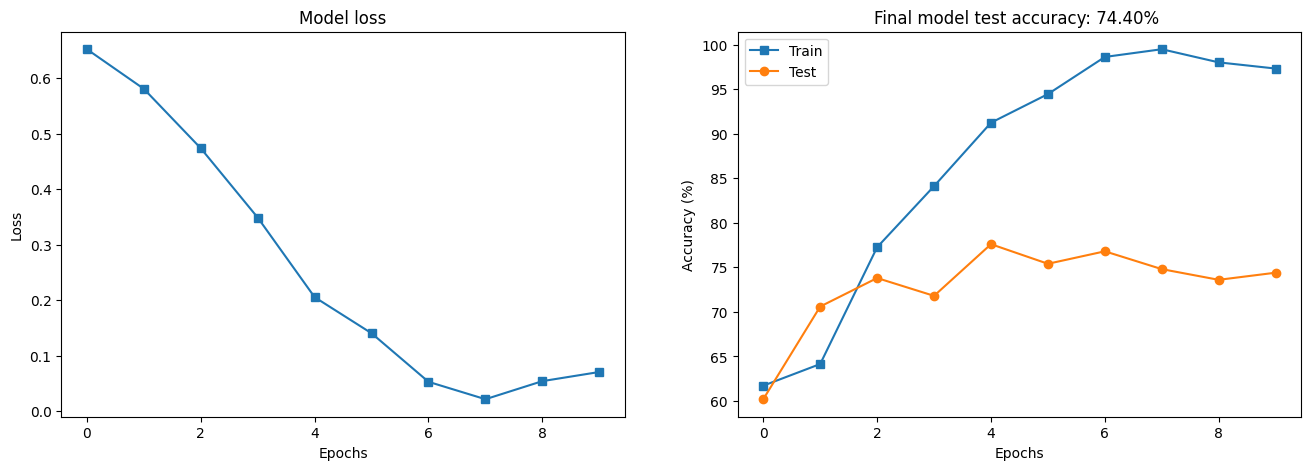

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}% ')
ax[1].legend()

plt.show()

In [ ]:
torch.save(net.state_dict(), "model.pt")